In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage.color import rgb2grey
from skimage import img_as_ubyte
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

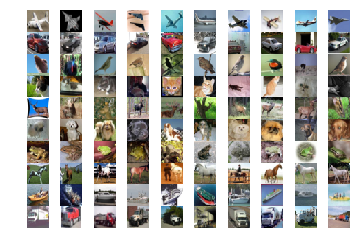

In [2]:
index = pd.read_csv(os.path.join('data','index.csv'))
labels = index['label'].unique()
fig, axes = plt.subplots(10, 10)
for label in labels:
    selected_images = index[index['label']==label].sample(10)
    for i in range(10):
        img = np.load(os.path.join('data','images',selected_images['filename'].iloc[i]+'.npy'))
        axes[label, i].imshow(img)
        axes[label, i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Histogram of Oriented is used to extract 324 features from each image.

In [3]:
def get_hog_features(filename):
    img = np.load(os.path.join('data', 'images', filename + '.npy'))
    return hog(img, block_norm='L2', orientations=9, 
               pixels_per_cell=(8,8), cells_per_block=(2,2), transform_sqrt=True, multichannel=True)

index['hog'] = index['filename'].apply(get_hog_features)
X_train_hog = np.stack(index.loc[index['is_test'] == 0,]['hog'].tolist(), axis=0)
X_test_hog = np.stack(index.loc[index['is_test']  == 1,]['hog'].tolist(), axis=0)
Y_train = index.loc[index['is_test']  == 0, ]['label'].tolist()
Y_test = index.loc[index['is_test']  == 1, ]['label'].tolist()

In [10]:
print(X_train_hog.shape)

(50000, 324)


Multiclass SVM using default parameters is fit using those features.

Respectable 54% accuracy on the test set is achieved.

In [15]:
base_clf = svm.LinearSVC(C=1)
base_clf.fit(X_train_hog, Y_train))
print(base_clf.score(X_train_hog, Y_train))
print(base_clf.score(X_test_hog, Y_test))

0.56296
0.5496


In [4]:
def get_cnn_features(filename):
    return np.load(os.path.join('data', 'features', filename + '.npy'))

index['cnn_code'] = index['filename'].apply(get_cnn_features)
X_train_cnn = np.stack(index.loc[index['is_test'] == 0,]['cnn_code'].tolist(), axis=0)
X_test_cnn = np.stack(index.loc[index['is_test']  == 1,]['cnn_code'].tolist(), axis=0)

t-sne algorithm cannot be applied to data with 2024 dimensions, because of the computational complexity. Therefore PCA is applied to first to reduce data to more managable 50 dimensions. Then t-sne is used to reduce dimensionality to 2, so the data can be shown on a plot.

In [14]:
cnn_reduced_50 = PCA(n_components=50).fit_transform(np.concatenate((X_train_cnn, X_test_cnn), axis=0))
print(cnn_reduced_50.shape)

(60000, 50)


In [19]:
cnn_reduced_2 = TSNE(n_components=2, verbose=5, perplexity=10, learning_rate=500).fit_transform(cnn_reduced_50)
print(cnn_reduced_2.shape)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.151s...
[t-SNE] Computed neighbors for 60000 samples in 357.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

Images are presented as points in 2d and colored according to class labels.

We can see that points of the same class form, therefore linear classifier should achieve decent accuacy. However there is some class overlap.

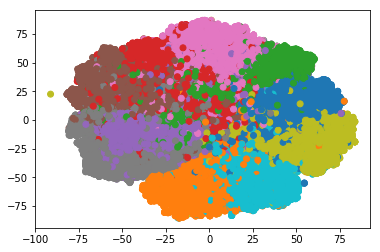

In [22]:
plt.scatter(cnn_reduced_2[:,0], cnn_reduced_2[:,1], c=Y_train+Y_test, cmap='tab10')
plt.show()

Unfortunately, due to time constraints only two fold cross validation could be formed. Due to fact that the parameter search was performed when fitting on only half of the training data set, values of regularization parameter C do not cause model to perform best on test set.

In [11]:
parameters={'C':[0.1, 1, 10]}
grid = GridSearchCV(svm.SVC(), parameters, cv=2, n_jobs=4, verbose=5)
grid.fit(X_train_cnn, Y_train)
print(grid.best_params_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] ............................... C=1, score=0.87088, total=45.2min
[CV] C=10 ............................................................
[CV] .................................. C=1, score=0.87, total=45.4min
[CV] C=10 ............................................................
[CV] .............................. C=10, score=0.88712, total=31.6min


[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed: 124.1min remaining: 124.1min


[CV] .............................. C=10, score=0.88916, total=31.7min
[CV] ............................. C=0.1, score=0.84208, total=82.3min
[CV] ............................. C=0.1, score=0.83872, total=83.3min


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed: 125.2min finished


{'C': 10}


10 turns out too big value for C and causes model to overfit.

In [13]:
cnn_clf_10 = svm.LinearSVC(C=grid.best_params_['C'])
cnn_clf_10.fit(X_train_cnn, Y_train)
print(cnn_clf_10.score(X_test_cnn, Y_test))

0.8482


Model generalizes better with stronger regularization (C=0.1)

In [14]:
cnn_clf_01 = svm.LinearSVC(C=0.1)
cnn_clf_01.fit(X_train_cnn, Y_train)
print(cnn_clf_01.score(X_test_cnn, Y_test))

0.8812


Confusion matrix of classification results on the test set is presented below.

Two pairs of most often confused classes are 

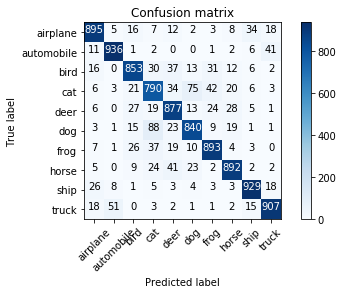

In [23]:
import sklearn.metrics
import itertools

predictions = cnn_clf_01.predict(X_test_cnn)
confusion_matrix = sklearn.metrics.confusion_matrix(Y_test, predictions)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
              'frog', 'horse', 'ship', 'truck']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_names,
                  title='Confusion matrix')
plt.show()